## Prior CO2 cov matrix



In [1]:
from datetime import date
import xarray as xr
import numpy as np
import sys
import os

def haversine_distance(lat, lon):
    """
    Calculate pairwise distances between points using Haversine formula.

    Parameters:
    - lat (ndarray) : 1-d array of latitude coordinates
    - lon (ndarray) : 1-d array of longitude coordinates
    Returns:
    - distances (ndarray): Pairwise distances matrix.
    """

    # Earth radius in kilometers
    earth_radius = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)

    # Compute differences in latitude and longitude
    dlat = lat_rad[:, np.newaxis] - lat_rad
    dlon = lon_rad[:, np.newaxis] - lon_rad

    # Haversine formula
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_rad) * np.cos(lat_rad[:, np.newaxis]) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate pairwise distances in kilometers
    distances = earth_radius * c

    return distances



def pick_area(lsm, latmin, latmax, lonmin, lonmax):
     lsm = lsm.where((latmin <= lsm.latitude) & (lsm.latitude <= latmax)
          &(lonmin <= lsm.longitude)& (lsm.longitude <= lonmax), drop=True) 
     return lsm
    

def compute_cov(lsm_flat, sigmas, L, prop_land = 0.5):

    nstate = lsm_flat.shape[0]
    #binary sea-land
    lsm_flat[lsm_flat <= prop_land] = 0
    lsm_flat[lsm_flat > prop_land] = 1
    #sort so that land cells first, then sea
    lsm_flat = lsm_flat.sortby(lsm_flat, ascending=False)
    #number of land gridcells = sum of land values
    nland = int(sum(lsm_flat.values))
    print(f"number of land cells: {nland}")
    #initialize cov matrix
    cov = np.zeros((nstate, nstate))
    lat = lsm_flat["latitude"].values
    lon = lsm_flat["longitude"].values

    #compute covariances separately for land and ocean 
    for v in ["land", "ocean"]:
        if v == "land":
            inds = [0, nland]
       
        else:
            inds = [nland, nstate]

        latv = lat[inds[0]:inds[1]]
        lonv = lon[inds[0]:inds[1]]  
        dists = haversine_distance(latv, lonv)
        sigma = sigmas[v]
        l = L[v]
        cov[inds[0]:inds[1], inds[0]:inds[1]] = sigma**2*np.exp(-1*(dists/l))
        
    return cov, lat, lon
    

def create_dataset(covariance, lat, lon):
    
    """
    Creates an xarray dataset of the covariance matrix and coordinates of the grid.
    """
    out_cov = xr.Dataset(
        data_vars={"covariance": (["nparams", "nparams"], covariance)},
        coords={"lon": (["nparams"], np.asarray(lon).flatten()),
                  "lat": (["nparams"], np.asarray(lat).flatten()),},
        attrs={'comment': f"Prior covariance for CO2 bio fluxes"}
    )
    return out_cov



In [2]:
lsm

NameError: name 'lsm' is not defined

In [26]:


#land-sea-mask_0.1x0.1deg
PATHTOMASK = '/home/pietaril/Documents/data/masks'

lsm = xr.open_dataset(os.path.join(PATHTOMASK, "lsm_1279l4_0.1x0.1.grb_v4_unpack.nc"))["lsm"][0]
clake = xr.open_dataset(os.path.join(PATHTOMASK, "clake.nc"))["cl"][0]
#change longitude coordinates from 0:360  to -180:180

lsm = lsm.assign_coords(longitude=(((lsm.longitude + 180) % 360) - 180))
clake = clake.assign_coords(longitude=(((clake.longitude + 180) % 360) - 180))
#sort  so that longitude values ascending
lsm = lsm.sortby(lsm.longitude)
clake = clake.sortby(clake.longitude)

#Finland - approx  latitude: 59.6 - 70.1, longitude: 19.3 -31.6
#Europe: lat 35-74, lon -12-39
latmin = 35
latmax = 74
lonmin= -12
lonmax = 39


lsm_eur = pick_area(lsm, latmin, latmax, lonmin, lonmax)
clake_eur = pick_area(clake, latmin, latmax, lonmin, lonmax)
#flatten
lsm_eur_flat = lsm_eur.stack(latlon=("latitude", "longitude"))

# Uncertainty (std)
sigmas = {'land': 0.8,
          'ocean': 1.2} 


# Correlation length (km)
L = {'land': 100,  # 
     'ocean': 500}  # for ocean

#compute cov matrix and coordinates ordered so that first land then ocean
#cov, lat, lon = compute_cov(lsm_flat, sigmas, L)



In [27]:
clake

<xarray.DataArray 'cl' (latitude: 1801, longitude: 3600)>
[6483600 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
    time       datetime64[ns] 2013-11-29
Attributes:
    units:      (0 - 1)
    long_name:  Lake cover

In [5]:
lsm_eur

<xarray.DataArray 'lsm' (latitude: 391, longitude: 511)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])
Coordinates:
  * longitude  (longitude) float32 -12.0 -11.9 -11.8 -11.7 ... 38.8 38.9 39.0
  * latitude   (latitude) float32 74.0 73.9 73.8 73.7 ... 35.3 35.2 35.1 35.0
    time       datetime64[ns] 2013-11-29
Attributes:
    units:          (0 - 1)
    long_name:      Land-sea mask
    standard_name:  land_binary_mask

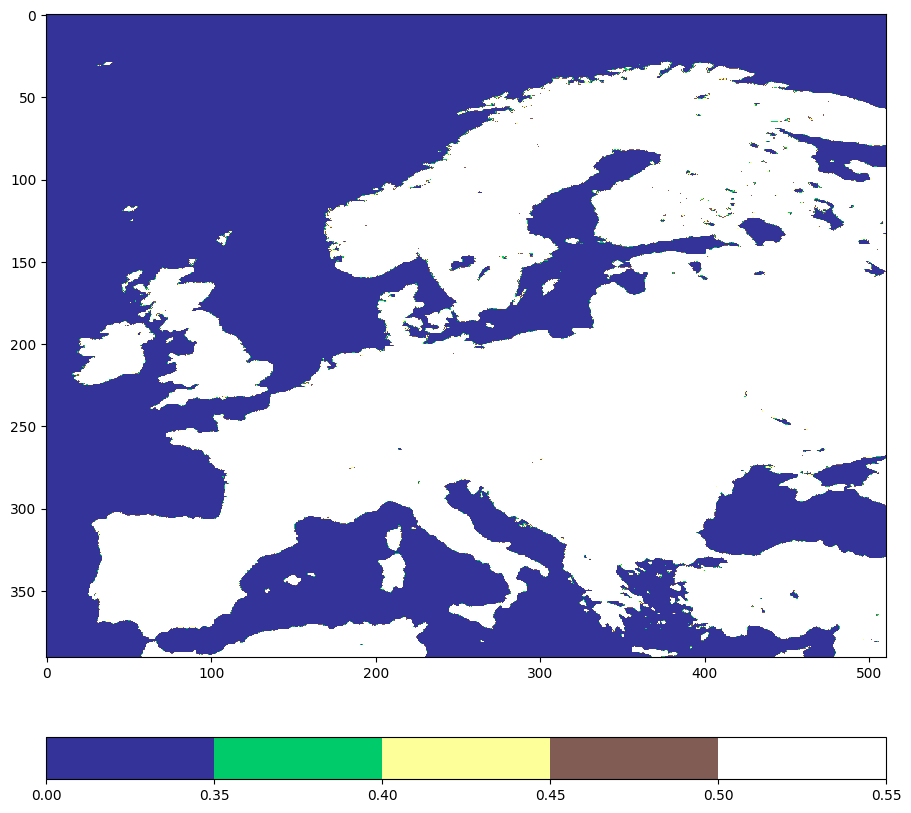

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 11), layout='constrained')


bounds = [0., 0.35, 0.4, 0.45,  0.5, 0.55]
pcm = ax.imshow(lsm_eur, norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither'), cmap='terrain')
fig.colorbar(pcm, ax=ax, orientation='horizontal')
plt.show()

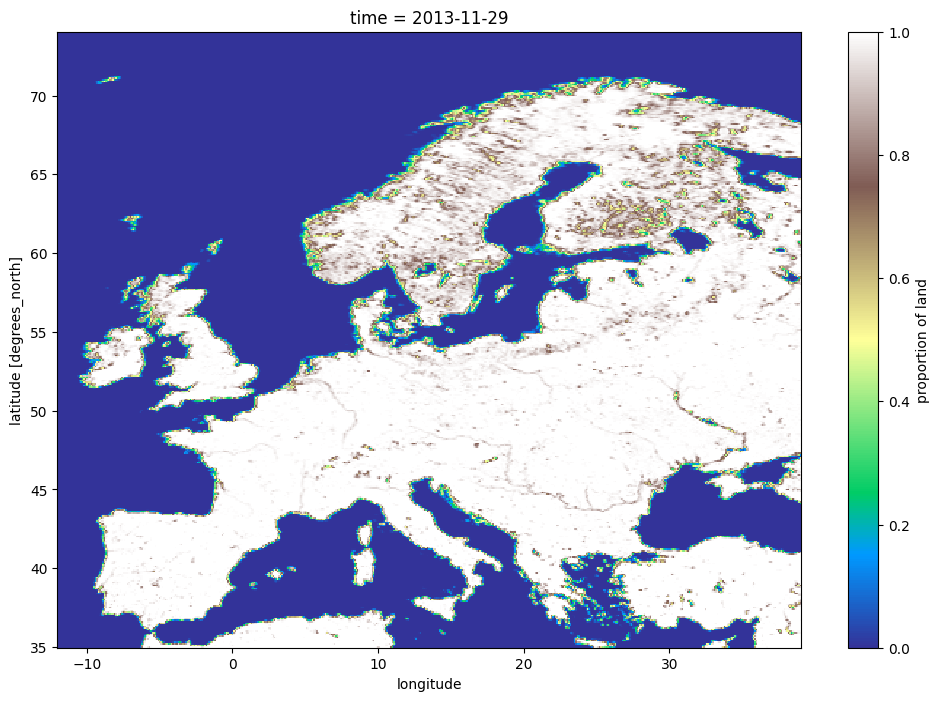

In [19]:
fig, ax = plt.subplots(figsize = (12,8))
pcm = lsm_eur.plot.pcolormesh(ax = ax, cmap = "terrain", cbar_kwargs={"label": "proportion of land"})


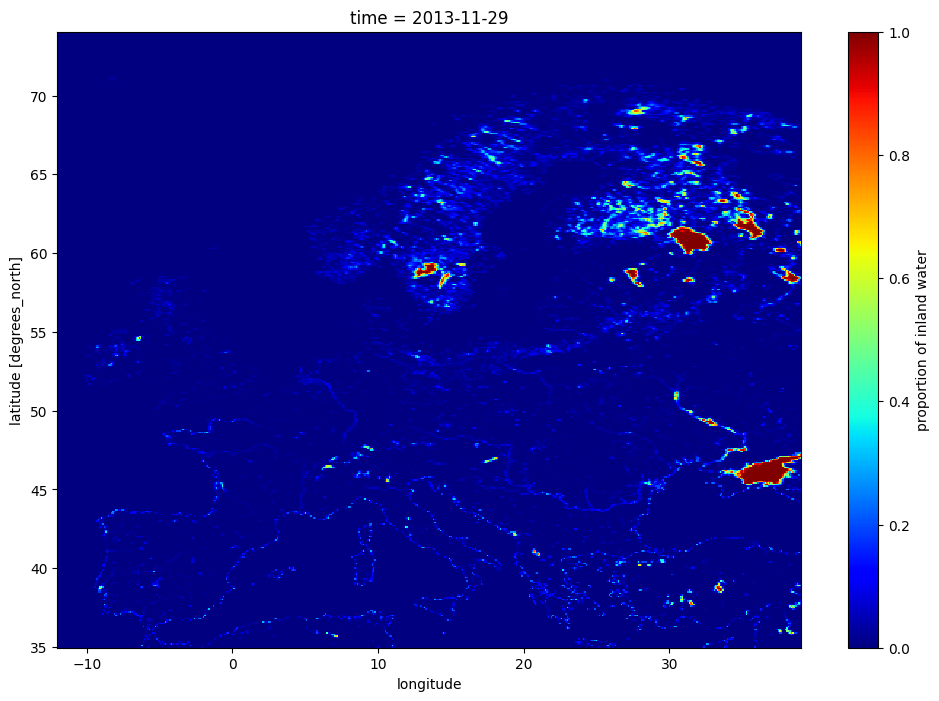

In [36]:
fig, ax = plt.subplots(figsize = (12,8))
pcm = clake_eur.plot.pcolormesh(ax = ax, cmap = "jet", cbar_kwargs={"label": "proportion of inland water"})

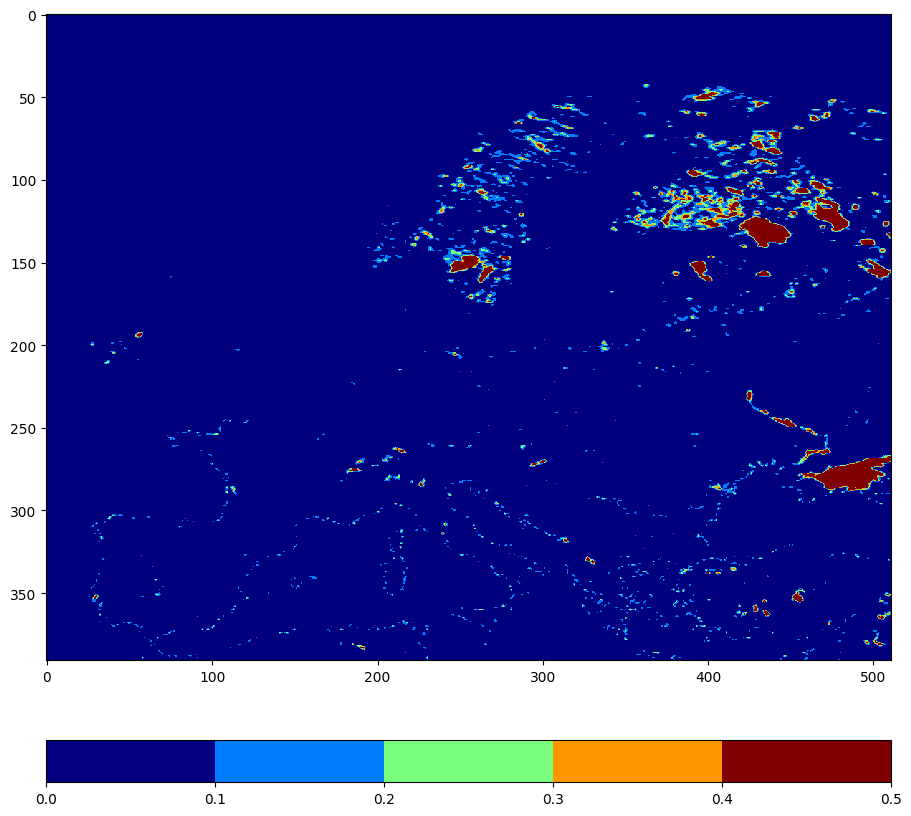

In [38]:
fig, ax = plt.subplots(figsize=(9, 11), layout='constrained')
bounds = [0., 0.1, 0.2, 0.3, 0.4, 0.5]
pcm = ax.imshow(clake_eur, norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither'), cmap='jet')
fig.colorbar(pcm, ax=ax, orientation='horizontal')
plt.show()

In [ ]:
#from Laia's auxiliary plot-function. I haven't modified this yet enough to work with my codes/data


fig, ax = plt.subplots(figsize=(12, 8), edgecolor='k', subplot_kw={'projection': projection})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.4, linestyle='--')
    ax.set_extent(aoi)
    ax.set_title(title1, fontsize=18)

    if len(data1.shape) == 1:
    # use scatter plot
    sc = ax.scatter(lon, lat, c=data1, cmap='viridis', transform=projection, s=0.85, alpha=1)
    plt.colorbar(sc, orientation='vertical')
    else:
    # use pcolormesh
    mesh = ax.pcolormesh(lon, lat, data1, cmap='viridis', transform=projection, alpha=0.7)
    cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label(label1)

In [36]:
prop_land = 0.5
lsm_eur_bin = lsm_eur_flat.copy(deep = True)
lsm_eur_bin[lsm_eur_flat <= prop_land] = 0
lsm_eur_bin[lsm_eur_flat > prop_land] = 1
lsm_eur_bin = lsm_eur_bin.unstack()

Text(0.5, 0.98, 'Proportion of land treshold 0.5')

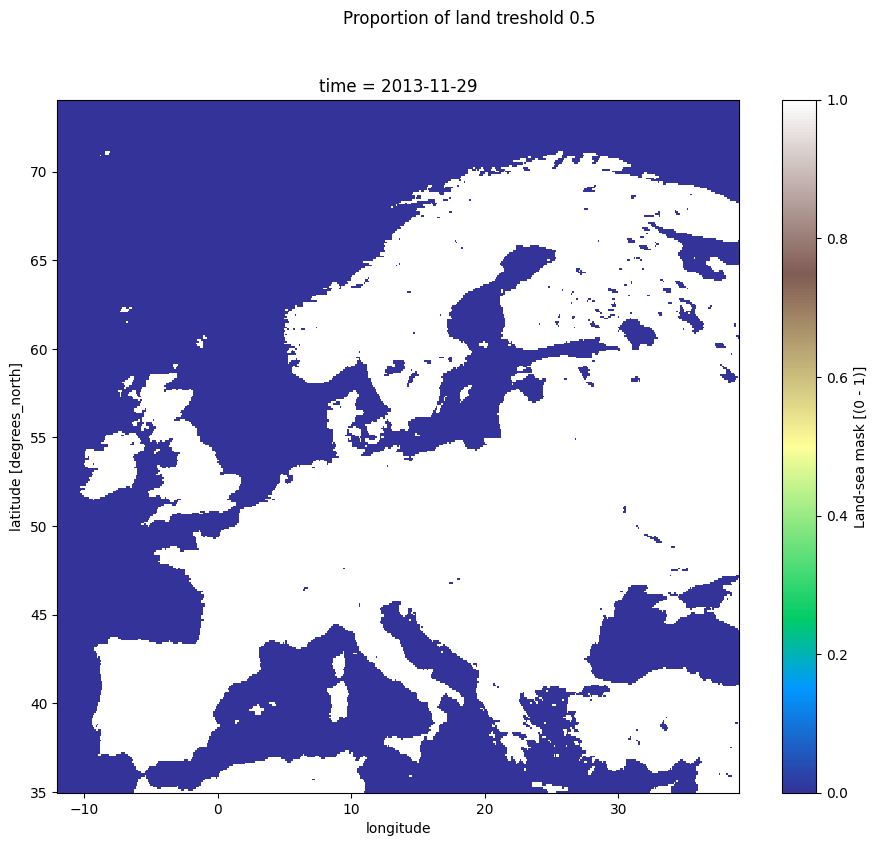

In [45]:

fig, ax = plt.subplots(figsize = (11,9))
lsm_eur_bin.plot.pcolormesh(ax = ax, cmap="terrain")
plt.suptitle(f"Proportion of land treshold {prop_land}")

Text(0.5, 0.98, 'Proportion of land treshold 0.4')

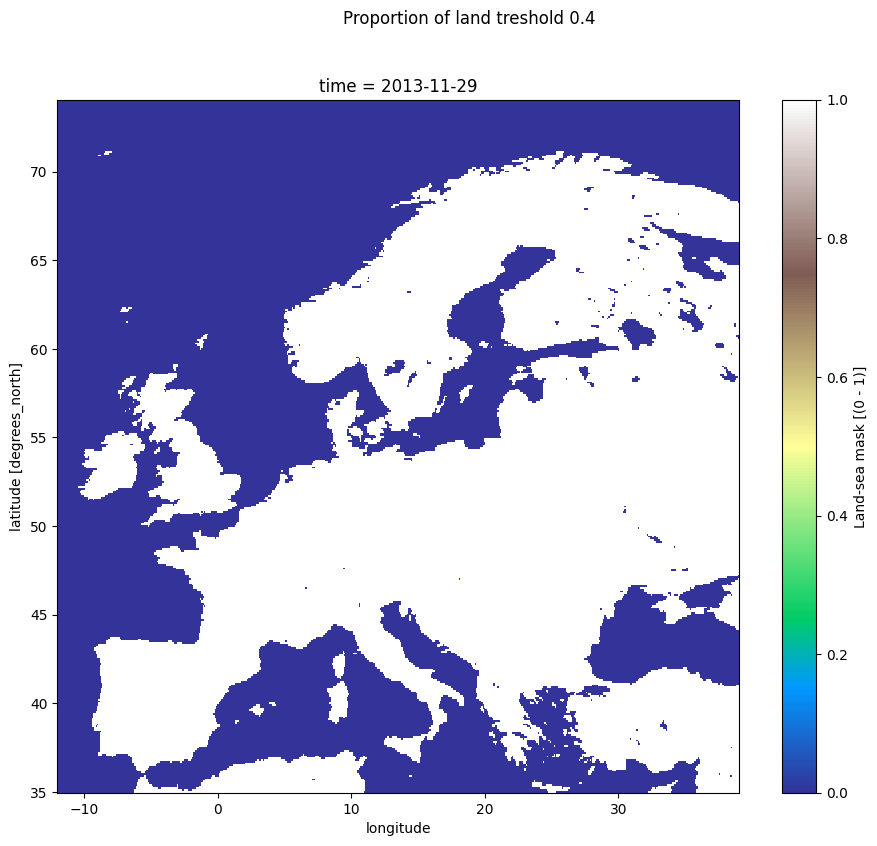

In [47]:
prop_land = 0.4
lsm_eur_bin = lsm_eur_flat.copy(deep = True)
lsm_eur_bin[lsm_eur_flat <= prop_land] = 0
lsm_eur_bin[lsm_eur_flat > prop_land] = 1
lsm_eur_bin = lsm_eur_bin.unstack()


fig, ax = plt.subplots(figsize = (11,9))
lsm_eur_bin.plot.pcolormesh(ax = ax, cmap="terrain")
plt.suptitle(f"Proportion of land treshold {prop_land}")

In [ ]:

# Output dataset

OUTPUT_PATH = '/home/pietaril/Documents/data/unc_cov_matrices'
today = date.today()
output_filename = 'CO2_prior_cov_fin_%04d%02d.nc' % (today.year, today.month)
out_cov = create_dataset(cov, lat, lon)
out_cov.to_netcdf(os.path.join(OUTPUT_PATH, output_filename))


In [6]:

i_lower = np.tril_indices(nr, -1) # lower triangular indices (excluding the diagonal)
cov[i_lower] = cov.T[i_lower]

cov = finalize(cov, sigmas)
dof = check(cov)
out_cov = write_dataarray(out_cov, cov, vv, nr, dof)

out_cov.to_netcdf('%s_cov.nc' % wfile.split('.nc')[0])


10605

In [10]:
cov.shape

(13144, 13144)

In [9]:
np.count_nonzero(np.diag(cov))

13144

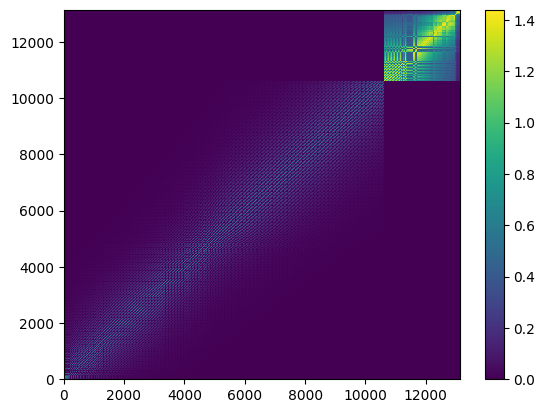

In [11]:
import matplotlib.pyplot as plt
plt.pcolormesh(cov)
plt.colorbar()

In [55]:
K = sigma**2*np.exp(-1*(dists/l))
K.shape

(872, 872)

In [50]:
dists/l

array([[0.        , 3.48890197, 0.28791411, ..., 1.93331381, 1.8981768 ,
        1.86317044],
       [3.48890197, 0.        , 3.23000923, ..., 1.89526896, 1.9313951 ,
        1.96761123],
       [0.28791411, 3.23000923, 0.        , ..., 1.6454348 , 1.61026768,
        1.57525887],
       ...,
       [1.93331381, 1.89526896, 1.6454348 , ..., 0.        , 0.03912315,
        0.07824552],
       [1.8981768 , 1.9313951 , 1.61026768, ..., 0.03912315, 0.        ,
        0.0391224 ],
       [1.86317044, 1.96761123, 1.57525887, ..., 0.07824552, 0.0391224 ,
        0.        ]])

The non-vectorized version:

In [73]:
ncount = range(0, 13100, 100)

nstate = lsm_flat.shape[0]
tresh_land = 0.5
#sort by proportion of land
lsm_flat = lsm_flat.sortby(lsm_flat, ascending=False)
lsm_flat[lsm_flat <= tresh_land] = 0
lsm_flat[lsm_flat > tresh_land] = 1
#number of land gridcells = sum of land values -1
nland = int(sum(lsm_flat.values))
cov0 = np.zeros((nstate, nstate))

for v in ["land", "ocean"]:
    if v == "land":
        inds = range(nland)
    else:
        inds = range(nland, nstate)
    for i in inds:
        if i in ncount:
            print(i)
        lat_i= lsm_flat["latitude"][i]
        lon_i = lsm_flat["longitude"][i]
        sigma = sigmas[v]
        l = L[v]

        # diagonal
        cov[i, i] = sigma**2

        #off-diagonals
        for j in range(inds[0],i):
            lat_j = lsm_flat["latitude"][j]
            lon_j = lsm_flat["longitude"][j]
            dist = points2distance(lat_i, lon_i, lat_j, lon_j)
            cov0[i,j] = (sigma**2)*(np.exp(-1*(dist/l)))
    
#i_lower = np.tril_indices(nstate, -1)
#cov[i_lower] = cov.T[i_lower]









   

0


* notes on tablet on how the CH4 priors constructed